[Reference](https://medium.com/bukalapak-data/time-series-anomaly-detection-simple-yet-powerful-approaches-4449ffe1ca12)

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import ParameterSampler
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")

In [ ]:
print(pd.__version__)
print(np.__version__)
print(sns.__version__)

1.1.5
1.19.5
0.11.2


In [ ]:
def performance_report(data):
    '''Function to generate performance report of the predicted anomaly event
    '''
    num_pred_positive = len(data[(data['label']==True)])
    
    if num_pred_positive == 0:
        return None
    else:
        num_positive = len(data[(data['anomaly']==True)])

        precision = len(data[(data['label']==True) & (data['anomaly']==True)])/num_pred_positive
        recall = len(data[(data['label']==True) & (data['anomaly']==True)])/num_positive

        if (precision==0) or (recall==0):
            return None
        else:
            f1 = 2*precision*recall/(precision+recall)

            return {'precision':precision,'recall':recall,'f1':f1}

        
def convert_to_non_consecutive_trigger(pred_date_series):
    '''Function to get the first trigger of consecutive predicted anomaly event
    '''
    non_consecutive_index = [0]
    for i in range(1,len(pred_date_series)):
        if ((pred_date_series.iloc[i] - pred_date_series.iloc[i-1]).seconds != 300*6):
            non_consecutive_index.append(i)
    non_consecutive_dates = [pred_date_series.iloc[i] for i in non_consecutive_index]
    return pd.Series(non_consecutive_dates)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/louisowen6/anomaly_detection/main/dummy_topup_data.csv')
df

,datetime,sum_amount,avg_amount_per_user,anomaly
0,2017-05-16 00:10:00,26.323942,16.474923,False
1,2017-05-16 00:40:00,25.363050,15.325484,False
2,2017-05-16 01:10:00,25.443192,11.128038,False
3,2017-05-16 01:40:00,26.149407,10.833380,False
4,2017-05-16 02:10:00,25.801580,10.858455,False
...,...,...,...,...
12269,2018-01-26 14:40:00,26.103956,13.934151,False
12270,2018-01-26 15:10:00,26.499405,14.409160,False
12271,2018-01-26 15:40:00,26.380532,14.416234,False
12272,2018-01-26 16:10:00,26.207231,14.174578,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12274 entries, 0 to 12273
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             12274 non-null  object 
 1   sum_amount           12274 non-null  float64
 2   avg_amount_per_user  12274 non-null  float64
 3   anomaly              12274 non-null  bool   
dtypes: bool(1), float64(2), object(1)
memory usage: 299.8+ KB


In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime').sort_index()

In [ ]:
# Moving Average
df['sum_amount_ma_5'] = df['sum_amount'].rolling(5).mean().ffill().bfill()
df['avg_amount_per_user_ma_5'] = df['avg_amount_per_user'].rolling(5).mean().ffill().bfill()

# Rolling z-score (basically by performing standardization on the rolling window)
df['sum_amount_zscore_10'] = ((df['sum_amount'] - df['sum_amount'].rolling(10).mean())/
                              df['sum_amount'].rolling(10).std()).ffill().bfill()
df['avg_amount_per_user_zscore_10'] = ((df['avg_amount_per_user'] - df['avg_amount_per_user'].rolling(10).mean())/
                                       df['avg_amount_per_user'].rolling(10).std()).ffill().bfill()

In [ ]:
df

,sum_amount,avg_amount_per_user,anomaly,sum_amount_ma_5,avg_amount_per_user_ma_5,sum_amount_zscore_10,avg_amount_per_user_zscore_10
datetime,,,,,,,
2017-05-16 00:10:00,26.323942,16.474923,False,25.816234,12.924056,0.370560,0.036218
2017-05-16 00:40:00,25.363050,15.325484,False,25.816234,12.924056,0.370560,0.036218
2017-05-16 01:10:00,25.443192,11.128038,False,25.816234,12.924056,0.370560,0.036218
2017-05-16 01:40:00,26.149407,10.833380,False,25.816234,12.924056,0.370560,0.036218
2017-05-16 02:10:00,25.801580,10.858455,False,25.816234,12.924056,0.370560,0.036218
...,...,...,...,...,...,...,...
2018-01-26 14:40:00,26.103956,13.934151,False,26.931094,14.584182,-1.522015,-1.270594
2018-01-26 15:10:00,26.499405,14.409160,False,26.912292,14.642117,-0.865601,-0.429957
2018-01-26 15:40:00,26.380532,14.416234,False,26.544841,14.375585,-0.856319,-0.390570


# EDA
## Anomaly Event Distribution


In [ ]:
100 * df['anomaly'].value_counts(True)

False    99.665961
True      0.334039
Name: anomaly, dtype: float64

In [ ]:
list(df[df['anomaly']==True].index)

[Timestamp('2017-09-25 04:40:00'),
 Timestamp('2017-09-25 05:10:00'),
 Timestamp('2017-11-12 01:40:00'),
 Timestamp('2017-11-12 08:40:00'),
 Timestamp('2017-11-12 09:10:00'),
 Timestamp('2017-11-12 09:40:00'),
 Timestamp('2017-11-12 10:10:00'),
 Timestamp('2017-11-12 10:40:00'),
 Timestamp('2017-11-12 11:10:00'),
 Timestamp('2017-11-12 11:40:00'),
 Timestamp('2017-11-12 12:10:00'),
 Timestamp('2017-11-12 12:40:00'),
 Timestamp('2017-11-12 13:10:00'),
 Timestamp('2017-11-12 13:40:00'),
 Timestamp('2018-01-03 00:10:00'),
 Timestamp('2018-01-03 00:40:00'),
 Timestamp('2018-01-03 01:10:00'),
 Timestamp('2018-01-03 01:40:00'),
 Timestamp('2018-01-03 02:10:00'),
 Timestamp('2018-01-03 02:40:00'),
 Timestamp('2018-01-03 03:10:00'),
 Timestamp('2018-01-03 03:40:00'),
 Timestamp('2018-01-03 04:10:00'),
 Timestamp('2018-01-03 04:40:00'),
 Timestamp('2018-01-03 05:10:00'),
 Timestamp('2018-01-03 05:40:00'),
 Timestamp('2018-01-03 06:10:00'),
 Timestamp('2018-01-03 06:40:00'),
 Timestamp('2018-01-

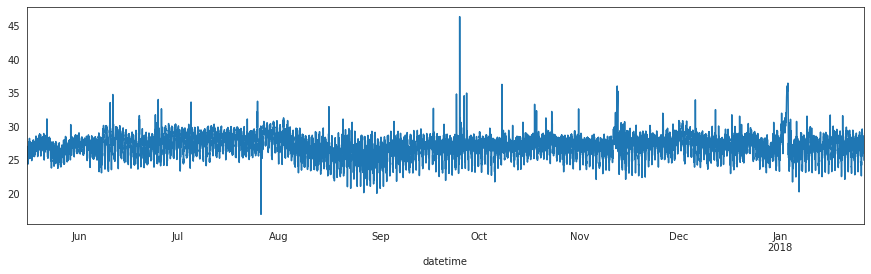

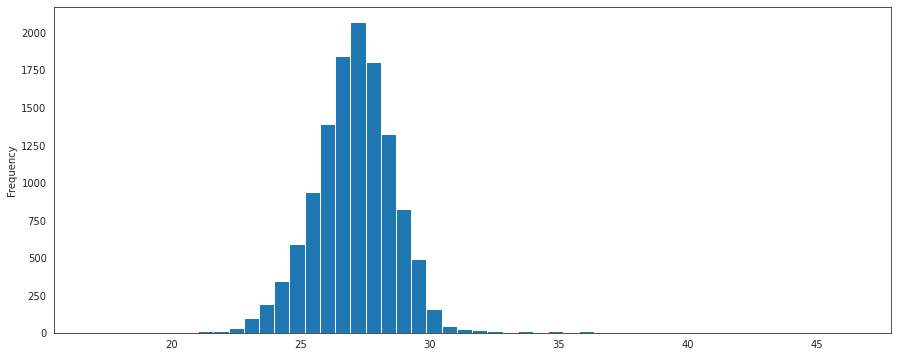

In [ ]:
df['sum_amount'].plot(figsize=(15,4))
plt.show()

df['sum_amount'].plot(figsize=(15,6),kind='hist',bins=50)
plt.show()

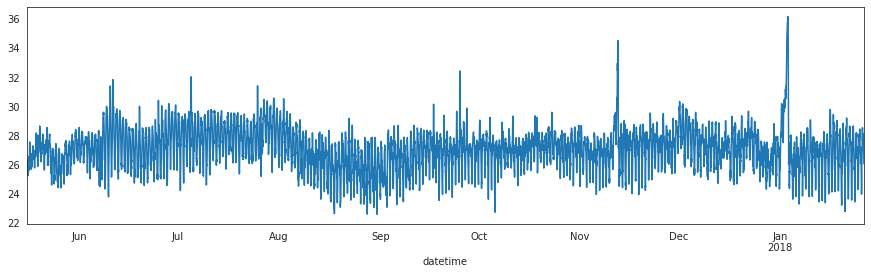

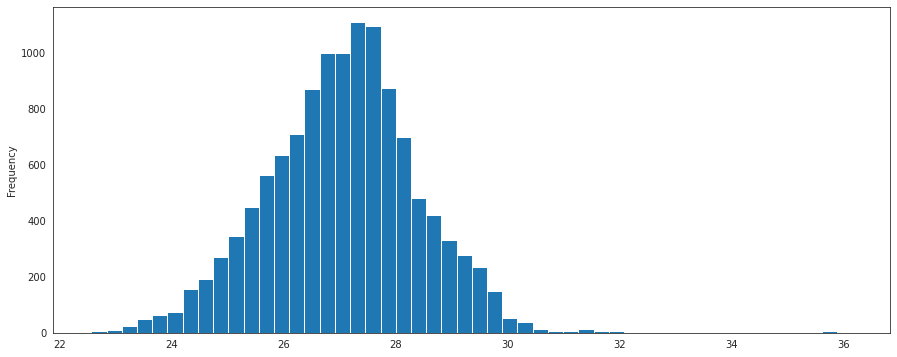

In [ ]:
df['sum_amount_ma_5'].plot(figsize=(15,4))
plt.show()

df['sum_amount_ma_5'].plot(figsize=(15,6),kind='hist',bins=50)
plt.show()

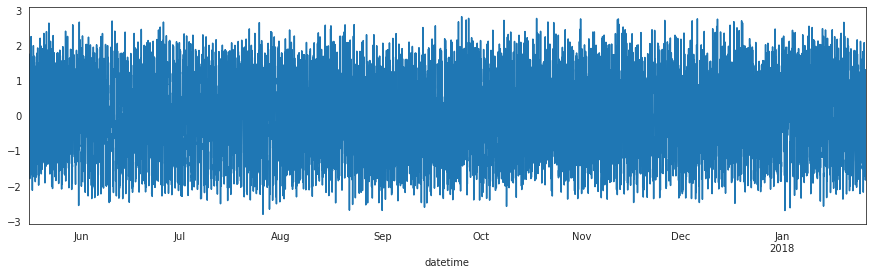

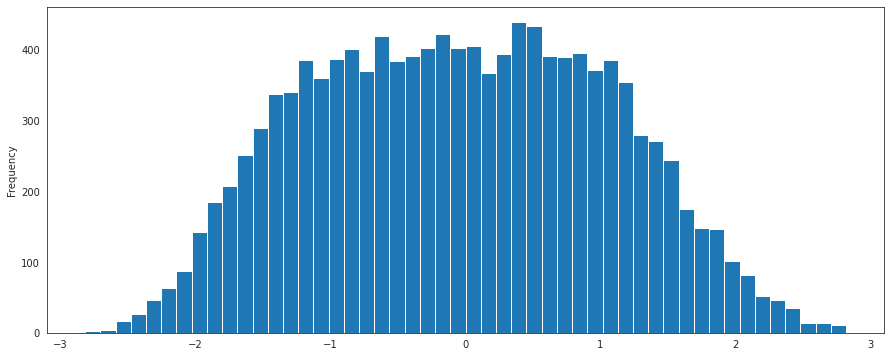

In [ ]:
df['sum_amount_zscore_10'].plot(figsize=(15,4))
plt.show()

df['sum_amount_zscore_10'].plot(figsize=(15,6),kind='hist',bins=50)
plt.show()

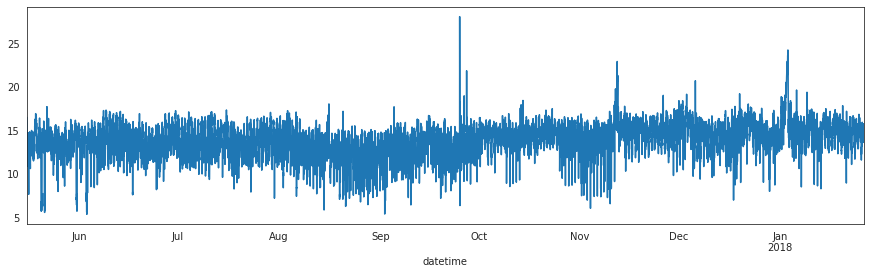

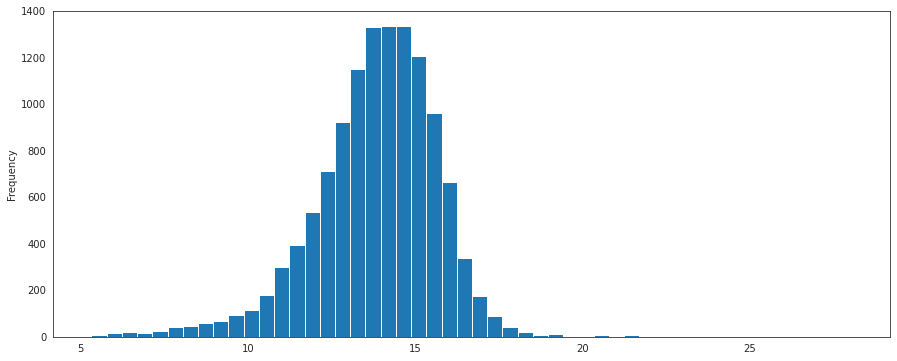

In [ ]:
df['avg_amount_per_user'].plot(figsize=(15,4))
plt.show()

df['avg_amount_per_user'].plot(figsize=(15,6),kind='hist',bins=50)
plt.show()

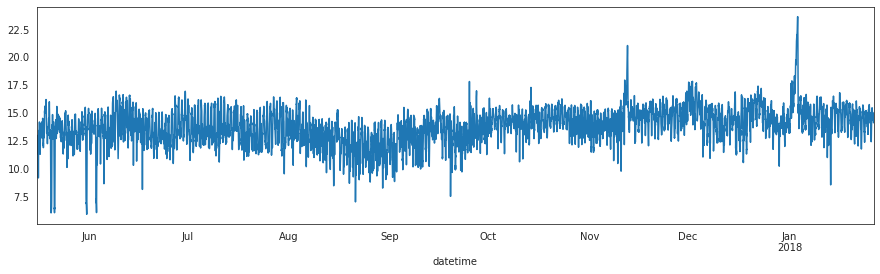

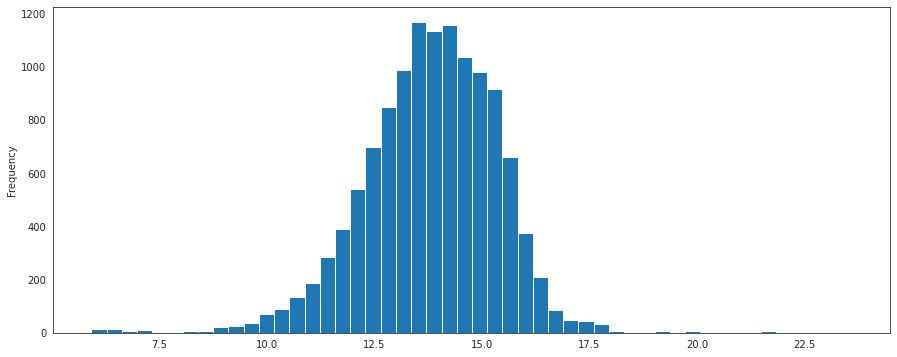

In [ ]:
df['avg_amount_per_user_ma_5'].plot(figsize=(15,4))
plt.show()

df['avg_amount_per_user_ma_5'].plot(figsize=(15,6),kind='hist',bins=50)
plt.show()

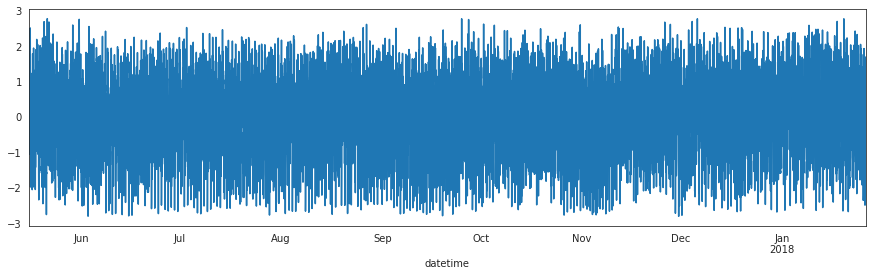

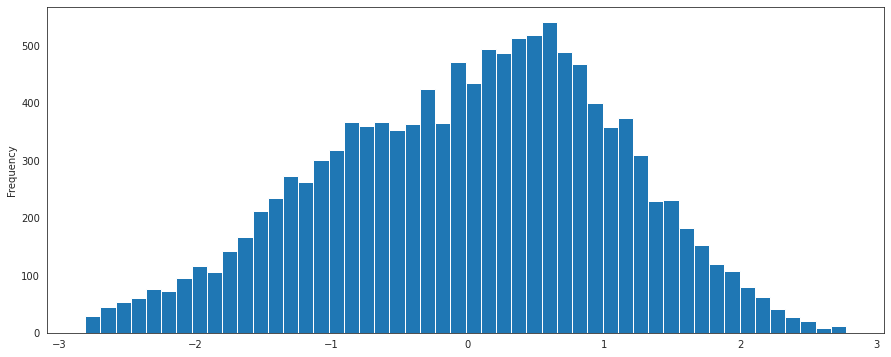

In [ ]:
df['avg_amount_per_user_zscore_10'].plot(figsize=(15,4))
plt.show()

df['avg_amount_per_user_zscore_10'].plot(figsize=(15,6),kind='hist',bins=50)
plt.show()

# Anomaly Detection Experiment
We will experiment with 3 types of anomaly detection techniques:

- Static Thresholding
- Dynamic Thresholding
- Isolation Forest

In [ ]:
baseline_df = df.copy()
BB_multiplier = 0.5

# Moving Standard Deviation
baseline_df['sum_amount_std_5'] = baseline_df['sum_amount'].rolling(5).std().ffill().bfill()
baseline_df['avg_amount_per_user_std_5'] = baseline_df['avg_amount_per_user'].rolling(5).std().ffill().bfill()

# Calculating the Standard Deviation Band
baseline_df['sum_upper_bb'] = baseline_df['sum_amount_ma_5'] + BB_multiplier * baseline_df['sum_amount_std_5']
baseline_df['avg_amount_per_user_upper_bb'] = baseline_df['avg_amount_per_user_ma_5'] + \
                                        BB_multiplier * baseline_df['avg_amount_per_user_std_5']

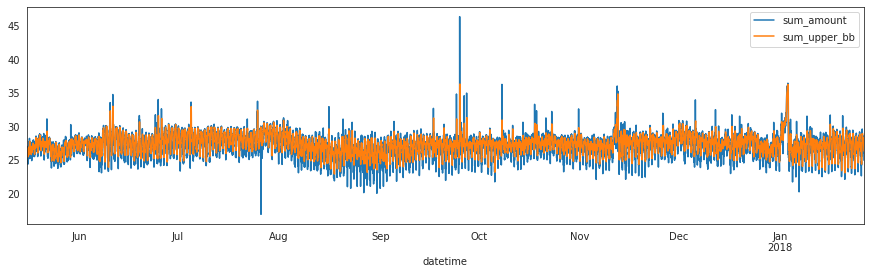

In [ ]:
baseline_df[['sum_amount','sum_upper_bb']].plot(figsize=(15,4))
plt.show()

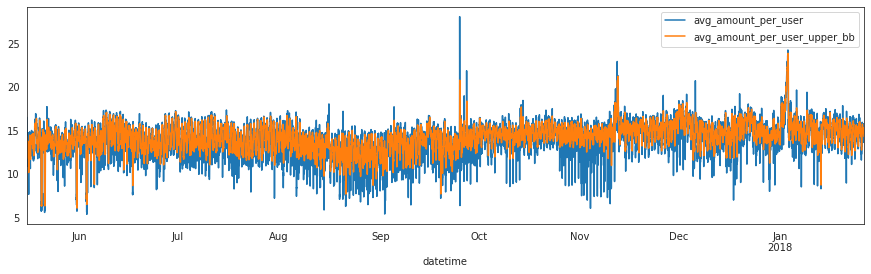

In [ ]:
baseline_df[['avg_amount_per_user','avg_amount_per_user_upper_bb']].plot(figsize=(15,4))
plt.show()

In [ ]:
pred_pos_label = baseline_df[(baseline_df.sum_amount >= baseline_df.sum_upper_bb) &\
                            (baseline_df.avg_amount_per_user >= baseline_df.avg_amount_per_user_upper_bb)
                            ].index

baseline_df.loc[:, 'label'] = False
baseline_df.loc[baseline_df.index.isin(pred_pos_label), 'label'] = True
score_dict = performance_report(baseline_df)
print(score_dict)

pred_date_series = convert_to_non_consecutive_trigger(pd.Series(pred_pos_label))

print(f'\nTotal Non Consecutive Triggers: {len(pred_date_series)}')

pred_date_series

{'precision': 0.005521273140630075, 'recall': 0.4146341463414634, 'f1': 0.010897435897435897}

Total Non Consecutive Triggers: 1938


0      2017-05-16 00:10:00
1      2017-05-16 03:10:00
2      2017-05-16 07:40:00
3      2017-05-16 09:40:00
4      2017-05-16 14:40:00
               ...        
1933   2018-01-25 16:40:00
1934   2018-01-25 23:40:00
1935   2018-01-26 01:10:00
1936   2018-01-26 03:40:00
1937   2018-01-26 13:10:00
Length: 1938, dtype: datetime64[ns]

## Static Thresholding

In [ ]:
static_threshold_df = df.copy()

In [ ]:
TUNE_ITER = 10_000

param_grid = {'sum_thres':list(np.linspace(27,35,100)), 
              'avg_thres': list(np.linspace(13,20,100)),
              'sum_ma_5_thres': list(np.linspace(27,35,100)),
              'avg_ma_5_thres':list(np.linspace(13,20,100)),
              'sum_zscore_10_thres':list(np.linspace(-5,5,100)),
             'avg_zscore_10_thres':list(np.linspace(-5,5,100))}
param_list = list(ParameterSampler(param_grid, n_iter=TUNE_ITER,random_state=0))

In [ ]:
results_dict = {}

for tune_iter in tqdm(range(TUNE_ITER)):
    strategy_params = param_list[tune_iter]
    pred_pos_label = static_threshold_df[(static_threshold_df.sum_amount >= strategy_params["sum_thres"]) &\
                                        (static_threshold_df.avg_amount_per_user >= strategy_params["avg_thres"]) &\
                                        (static_threshold_df.sum_amount_ma_5 >= strategy_params["sum_ma_5_thres"]) &\
                                        (static_threshold_df.avg_amount_per_user_ma_5 >= strategy_params["avg_ma_5_thres"]) &\
                                        (static_threshold_df.sum_amount_zscore_10 >= strategy_params["sum_zscore_10_thres"]) &\
                                        (static_threshold_df.avg_amount_per_user_zscore_10 >= strategy_params["avg_zscore_10_thres"])
                                        ].index
    
    static_threshold_df.loc[:, 'label'] = False
    static_threshold_df.loc[static_threshold_df.index.isin(pred_pos_label), 'label'] = True
    score_dict = performance_report(static_threshold_df)
    
    if score_dict is not None:
        results_dict[tuple(strategy_params.values())] = score_dict['f1']

# Aggregating Results
df_results = pd.DataFrame({'fitness':results_dict}).reset_index()
df_results.columns = list(strategy_params.keys()) + ['fitness']
best_params = df_results.sort_values(by='fitness',ascending=False).head(1).reset_index(drop=True).drop(columns='fitness').T.to_dict()[0]
best_fitness = df_results.sort_values(by='fitness',ascending=False).head(1)['fitness'].values[0]

100%|██████████| 10000/10000 [01:12<00:00, 138.17it/s]


In [ ]:
best_fitness, best_params

(0.9620253164556963,
 {'avg_ma_5_thres': 17.242424242424242,
  'avg_thres': 14.767676767676768,
  'avg_zscore_10_thres': -3.484848484848485,
  'sum_ma_5_thres': 31.848484848484848,
  'sum_thres': 30.232323232323232,
  'sum_zscore_10_thres': -4.393939393939394})

In [ ]:
pred_pos_label = static_threshold_df[(static_threshold_df.sum_amount >= best_params["sum_thres"]) &\
                                    (static_threshold_df.avg_amount_per_user >= best_params["avg_thres"]) &\
                                    (static_threshold_df.sum_amount_ma_5 >= best_params["sum_ma_5_thres"]) &\
                                    (static_threshold_df.avg_amount_per_user_ma_5 >= best_params["avg_ma_5_thres"]) &\
                                    (static_threshold_df.sum_amount_zscore_10 >= best_params["sum_zscore_10_thres"]) &\
                                    (static_threshold_df.avg_amount_per_user_zscore_10 >= best_params["avg_zscore_10_thres"])
                                    ].index

static_threshold_df.loc[:, 'label'] = False
static_threshold_df.loc[static_threshold_df.index.isin(pred_pos_label), 'label'] = True
score_dict = performance_report(static_threshold_df)
print(score_dict)

pred_date_series = convert_to_non_consecutive_trigger(pd.Series(pred_pos_label))

print(f'\nTotal Non Consecutive Triggers: {len(pred_date_series)}')

pred_date_series

{'precision': 1.0, 'recall': 0.926829268292683, 'f1': 0.9620253164556963}

Total Non Consecutive Triggers: 2


0   2017-11-12 08:40:00
1   2018-01-03 00:10:00
dtype: datetime64[ns]

## Dynamic Thresholding


In [ ]:
dynamic_threshold_df = df.copy()

In [ ]:
TUNE_ITER = 10_000

param_grid = {'sum_quantile':list(np.linspace(0,1,100)), 
              'avg_quantile': list(np.linspace(0,1,100)),
              'sum_ma_5_quantile': list(np.linspace(0,1,100)),
              'avg_ma_5_quantile':list(np.linspace(0,1,100)),
              'lookback_period': [i for i in range(8_000, 15000)]}
param_list = list(ParameterSampler(param_grid, n_iter=TUNE_ITER,random_state=0))

In [ ]:
results_dict = {}

for tune_iter in tqdm(range(TUNE_ITER)):
    strategy_params = param_list[tune_iter]
    
    dynamic_threshold_df['sum_amount_thres'] = dynamic_threshold_df['sum_amount'].rolling(strategy_params["lookback_period"],min_periods=1).quantile(strategy_params["sum_quantile"])
    dynamic_threshold_df['avg_amount_per_user_thres'] = dynamic_threshold_df['avg_amount_per_user'].rolling(strategy_params["lookback_period"],min_periods=1).quantile(strategy_params["avg_quantile"])
    dynamic_threshold_df['sum_amount_ma_5_thres'] = dynamic_threshold_df['sum_amount_ma_5'].rolling(strategy_params["lookback_period"],min_periods=1).quantile(strategy_params["sum_ma_5_quantile"])
    dynamic_threshold_df['avg_amount_per_user_ma_5_thres'] = dynamic_threshold_df['avg_amount_per_user_ma_5'].rolling(strategy_params["lookback_period"],min_periods=1).quantile(strategy_params["avg_ma_5_quantile"])
    
    pred_pos_label = dynamic_threshold_df[(dynamic_threshold_df.sum_amount >= dynamic_threshold_df.sum_amount_thres) &\
                            (dynamic_threshold_df.avg_amount_per_user >= dynamic_threshold_df.avg_amount_per_user_thres) &\
                            (dynamic_threshold_df.sum_amount_ma_5 >= dynamic_threshold_df.sum_amount_ma_5_thres) &\
                            (dynamic_threshold_df.avg_amount_per_user_ma_5 >= dynamic_threshold_df.avg_amount_per_user_ma_5_thres)
                            ].index
    
    dynamic_threshold_df.loc[:, 'label'] = False
    dynamic_threshold_df.loc[dynamic_threshold_df.index.isin(pred_pos_label), 'label'] = True
    score_dict = performance_report(dynamic_threshold_df)
    
    if score_dict is not None:
        results_dict[tuple(strategy_params.values())] = score_dict['f1']

# Aggregating Results
df_results = pd.DataFrame({'fitness':results_dict}).reset_index()
df_results.columns = list(strategy_params.keys()) + ['fitness']
best_params = df_results.sort_values(by='fitness',ascending=False).head(1).reset_index(drop=True).drop(columns='fitness').T.to_dict()[0]
best_fitness = df_results.sort_values(by='fitness',ascending=False).head(1)['fitness'].values[0]

100%|██████████| 10000/10000 [08:40<00:00, 19.21it/s]


In [ ]:
best_fitness, best_params

(0.6329113924050632,
 {'avg_ma_5_quantile': 1.0,
  'avg_quantile': 0.5555555555555556,
  'lookback_period': 8199.0,
  'sum_ma_5_quantile': 0.4747474747474748,
  'sum_quantile': 0.9595959595959597})

In [ ]:
dynamic_threshold_df['sum_amount_thres'] = dynamic_threshold_df['sum_amount'].rolling(int(best_params["lookback_period"]),min_periods=1).quantile(best_params["sum_quantile"])
dynamic_threshold_df['avg_amount_per_user_thres'] = dynamic_threshold_df['avg_amount_per_user'].rolling(int(best_params["lookback_period"]),min_periods=1).quantile(best_params["avg_quantile"])
dynamic_threshold_df['sum_amount_ma_5_thres'] = dynamic_threshold_df['sum_amount_ma_5'].rolling(int(best_params["lookback_period"]),min_periods=1).quantile(best_params["sum_ma_5_quantile"])
dynamic_threshold_df['avg_amount_per_user_ma_5_thres'] = dynamic_threshold_df['avg_amount_per_user_ma_5'].rolling(int(best_params["lookback_period"]),min_periods=1).quantile(best_params["avg_ma_5_quantile"])
   

pred_pos_label = dynamic_threshold_df[(dynamic_threshold_df.sum_amount >= dynamic_threshold_df.sum_amount_thres) &\
                            (dynamic_threshold_df.avg_amount_per_user >= dynamic_threshold_df.avg_amount_per_user_thres) &\
                            (dynamic_threshold_df.sum_amount_ma_5 >= dynamic_threshold_df.sum_amount_ma_5_thres) &\
                            (dynamic_threshold_df.avg_amount_per_user_ma_5 >= dynamic_threshold_df.avg_amount_per_user_ma_5_thres)
                            ].index

dynamic_threshold_df.loc[:, 'label'] = False
dynamic_threshold_df.loc[static_threshold_df.index.isin(pred_pos_label), 'label'] = True
score_dict = performance_report(dynamic_threshold_df)
print(score_dict)

pred_date_series = convert_to_non_consecutive_trigger(pd.Series(pred_pos_label))

print(f'\nTotal Non Consecutive Triggers: {len(pred_date_series)}')

pred_date_series

{'precision': 0.6578947368421053, 'recall': 0.6097560975609756, 'f1': 0.6329113924050632}

Total Non Consecutive Triggers: 14


0    2017-05-16 00:10:00
1    2017-05-16 15:40:00
2    2017-05-18 20:10:00
3    2017-06-08 07:40:00
4    2017-06-08 09:40:00
5    2017-06-08 10:40:00
6    2017-06-09 04:40:00
7    2017-06-09 07:10:00
8    2017-09-25 05:10:00
9    2017-11-12 07:40:00
10   2017-11-12 10:40:00
11   2018-01-03 03:10:00
12   2018-01-03 06:40:00
13   2018-01-03 08:10:00
dtype: datetime64[ns]

## Isolation Forest


In [ ]:
isolation_forest_df = df.copy()

In [ ]:
TUNE_ITER = 10_000

param_grid = {'short_ma_sum': [i for i in range(2, 100)], 
              'long_ma_sum': [i for i in range(5, 100)],
              'short_ma_avg': [i for i in range(2, 100)],
              'long_ma_avg': [i for i in range(5, 100)]}
param_list = list(ParameterSampler(param_grid, n_iter=TUNE_ITER,random_state=0))

In [37]:
results_dict = {}

fraction = len(isolation_forest_df[isolation_forest_df['anomaly']==True])/len(isolation_forest_df)

for tune_iter in tqdm(range(TUNE_ITER)):
    strategy_params = param_list[tune_iter]
    
    if (strategy_params["short_ma_sum"] < strategy_params["long_ma_sum"]) and (strategy_params["short_ma_avg"] < strategy_params["long_ma_avg"]):
        isolation_forest_df['sum_amount_ma_short'] = isolation_forest_df['sum_amount'].rolling(strategy_params["short_ma_sum"]).mean().ffill().bfill()
        isolation_forest_df['avg_amount_per_user_ma_short'] = isolation_forest_df['avg_amount_per_user'].rolling(strategy_params["short_ma_avg"]).mean().ffill().bfill()

        isolation_forest_df['sum_amount_ma_long'] = isolation_forest_df['sum_amount'].rolling(strategy_params["long_ma_sum"]).mean().ffill().bfill()
        isolation_forest_df['avg_amount_per_user_ma_long'] = isolation_forest_df['avg_amount_per_user'].rolling(strategy_params["long_ma_avg"]).mean().ffill().bfill()
        
        X = isolation_forest_df[['sum_amount','avg_amount_per_user',
                                 'sum_amount_ma_short','avg_amount_per_user_ma_short',
                                 'sum_amount_ma_long','avg_amount_per_user_ma_long']]

        clf = IsolationForest(random_state=123,contamination = fraction).fit(X)
        iforest_results = X.copy()
        iforest_results['Anomaly'] = clf.predict(X)
        iforest_results['Anomaly'] = iforest_results['Anomaly'].apply(lambda x: 0 if x==1 else 1)
        
        pred_pos_label = pd.Series(iforest_results[iforest_results['Anomaly']==1].index)

        isolation_forest_df.loc[:, 'label'] = False
        isolation_forest_df.loc[isolation_forest_df.index.isin(pred_pos_label), 'label'] = True
        score_dict = performance_report(isolation_forest_df)

        if score_dict is not None:
            results_dict[tuple(strategy_params.values())] = score_dict['f1']

# Aggregating Results
df_results = pd.DataFrame({'fitness':results_dict}).reset_index()
df_results.columns = list(strategy_params.keys()) + ['fitness']
best_params = df_results.sort_values(by='fitness',ascending=False).head(1).reset_index(drop=True).drop(columns='fitness').T.to_dict()[0]
best_fitness = df_results.sort_values(by='fitness',ascending=False).head(1)['fitness'].values[0]

Streaming output truncated to the last 5000 lines.
  5%|▍         | 474/10000 [01:47<16:53,  9.40it/s]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
  5%|▍         | 476/10000 [01:48<21:56,  7.23it/s]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
  5%|▍         | 477/10000 [01:49<29:23,  5.40it/s]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
  5%|▍         | 481/10000 [01:50<31:10,  5.09it/s]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest 

In [38]:
best_fitness, best_params

(0.9024390243902439,
 {'long_ma_avg': 44, 'long_ma_sum': 9, 'short_ma_avg': 26, 'short_ma_sum': 6})

In [39]:
fraction = len(isolation_forest_df[isolation_forest_df['anomaly']==True])/len(isolation_forest_df)

isolation_forest_df['sum_amount_ma_short'] = isolation_forest_df['sum_amount'].rolling(best_params["short_ma_sum"]).mean().ffill().bfill()
isolation_forest_df['avg_amount_per_user_ma_short'] = isolation_forest_df['avg_amount_per_user'].rolling(best_params["short_ma_avg"]).mean().ffill().bfill()

isolation_forest_df['sum_amount_ma_long'] = isolation_forest_df['sum_amount'].rolling(best_params["long_ma_sum"]).mean().ffill().bfill()
isolation_forest_df['avg_amount_per_user_ma_long'] = isolation_forest_df['avg_amount_per_user'].rolling(best_params["long_ma_avg"]).mean().ffill().bfill()

X = isolation_forest_df[['sum_amount','avg_amount_per_user',
                                 'sum_amount_ma_short','avg_amount_per_user_ma_short',
                                 'sum_amount_ma_long','avg_amount_per_user_ma_long']]

clf = IsolationForest(random_state=123,contamination = fraction).fit(X)
iforest_results = X.copy()
iforest_results['Anomaly'] = clf.predict(X)
iforest_results['Anomaly'] = iforest_results['Anomaly'].apply(lambda x: 0 if x==1 else 1)

pred_pos_label = pd.Series(iforest_results[iforest_results['Anomaly']==1].index)
isolation_forest_df.loc[:, 'label'] = False
isolation_forest_df.loc[isolation_forest_df.index.isin(pred_pos_label), 'label'] = True
score_dict = performance_report(isolation_forest_df)
print(score_dict)

pred_date_series = convert_to_non_consecutive_trigger(pd.Series(pred_pos_label))

print(f'\nTotal Non Consecutive Triggers: {len(pred_date_series)}')

pred_date_series

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


{'precision': 0.9024390243902439, 'recall': 0.9024390243902439, 'f1': 0.9024390243902439}

Total Non Consecutive Triggers: 4


0   2017-11-12 07:40:00
1   2017-11-12 09:10:00
2   2018-01-02 22:10:00
3   2018-01-02 23:10:00
dtype: datetime64[ns]